# Simulation du saut de Felix Baumgartner


Le 14 octobre 2012, Felix Baumgartner devient le premier homme à franchir le mur du son lors d’unsaut en chute libre. L’objectif de ce notebook est de simuler ce saut.


## Modélisation de la chute libre

D'après le principe fondamental de la dynamique:
$$
    m z^{''}(t) = -mg(z(t)) + \frac{1}{2}AC\rho\big(z(t)\big){z^{'}(t)}^2
$$

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Constante spécifique des gaz parfaits (Air) [J·kg-1·K-1] 
R = 287
# Rayon de la terre en mètres
RT = 6.371E6
# Constante gravitationnelle 6,674 30(15) × 10−11 m3 kg−1 s−2
G = 6.674301E-11
# Masse de la terre 5,9722 × 1024 kg
M = 5.9722E24
# G*M est une mesure plus précise
GM = 3.986004418E14


In [4]:
def geo_alt(z):
    """Calcul l'altitude géopotentielle pour une altitude donnée"""
    return z * RT / (z + RT)

def pesanteur(z):
    """Calcul de l'intensité de pesanteur à une altitude donnée"""
    return G*M/(RT + z)**2

def temperature_at(i, z):
    """Calcul de la température à un niveau d'altitude 
    et couche d'atmoshère données
    """
    return Ti[i] + ai[i] * (z - Zi[i])

def pressure_at(i, t):
    """Calcul de la pression à température et couche d'atmoshère données"""
    return pi[i] * (t / Ti[i])**(-pesanteur(0) / (ai[i] * R))

def constant_pressure_at(i, t, z):
    """Calcul de la pression à température, altitude et couche d'atmoshère données"""
    return pi[i] * np.exp(-pesanteur(0) / (R * t) * (z - Zi[i]))

def air_density(p, t):
    return p / (R * t)

def sound_speed(t):
    return np.sqrt(1.4 * R * t)

## Modélisation de l'atmosphère

In [5]:
# Tableau des différentes couches du modèle d'atmosphère
Zi = np.array([0, 11000, 20000, 32000])
Ti = np.array([288.15, 216.65, 216.65, 228.65])
ai = np.array([-.0065, 0, .001, .0028])
pi = np.array([101325, 22632.1, 5474.89, 868.019])

labels = ['Température', 'Préssion', 'Densité', 'Vitesse du Son']

def atmosphere(z):
    """Calcul les propriétés suivantes de l'atmosphère:
         - Température
         - pression
         - densité
         - vitesse du son
    """
    
    z = geo_alt(z)
    if Zi[0] <= z <= Zi[1]:
        temperature = temperature_at(0, z)
        pression = pressure_at(0, temperature)
        
    elif Zi[1] <= z <= Zi[2]:
        temperature = Ti[1] 
        pression =  constant_pressure_at(1, temperature, z)
        
    elif Zi[2] <= z <= Zi[3]:
        temperature = temperature_at(2, z)
        pression = pressure_at(2, temperature)
        
    elif z >= Zi[3]:
        temperature = temperature_at(3, z)
        pression = pressure_at(3, temperature)
    
    densite = air_density(pression, temperature)
    vitesse_son = sound_speed(temperature)
    
    return [temperature, pression, densite, vitesse_son]

In [6]:
x = np.linspace(0, 40000, 10000)
z = np.array(list(map(atmosphere, x)))

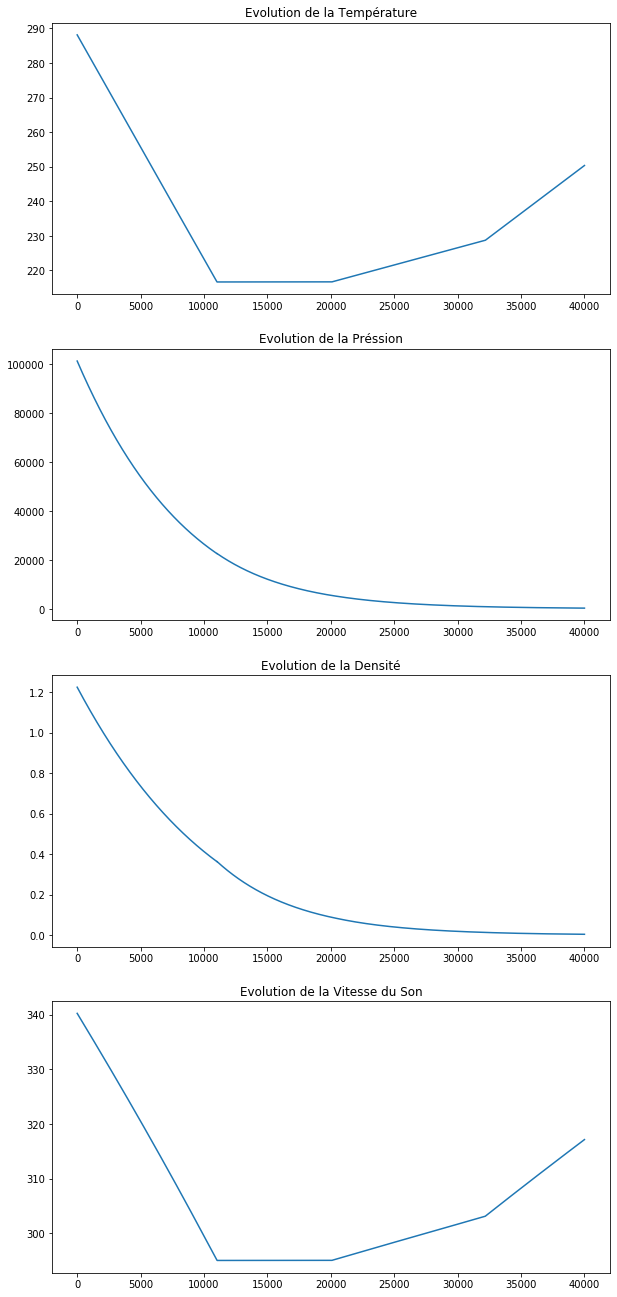

In [7]:
fig, axes = plt.subplots(4, 1, figsize=[10,23])
for i in range(4):
        axes[i].plot(x, z[:, i], label=labels[i])
        axes[i].set_title(f'Evolution de la {labels[i]}')

## Simulation du saut de Felix Baumgartner

In [8]:
def chute(dt, z0, m, C, A, plot=True, observed=False):
    u = [0]
    z = [z0]
    vs = [atmosphere(z0)[-1]]
    while z[-1] >= 0:
        ui, zi = u[-1], z[-1]
        _, _, rho, s = atmosphere(zi)
        g = pesanteur(zi)

        vs.append(s)
        u.append((ui + (-g + 0.5 * A * C * rho * ui**2/ m)))
        z.append(zi + ui)
    
    u = np.array(u)
    if plot:
        
        fig, ax = plt.subplots()
        ax.set_title(f'Evolution de la vitesse de Felix(simulation)\n $z_0 = {z0}$')
        ax.plot(z, -u, label='Simulated')
        ax.plot(z, vs, label='Sound')
        ax.set_xlabel('Altitude')
        ax.set_ylabel('Velocity')
        if observed:
            ax.set_title(f'Evolution de la vitesse (simulation vs observed)\n $z_0 = {z0}$')
            z_observed = np.array([38969, 33446, 27833, 22961, 7619, 2567])
            v_observed = np.array([0, 1115, 1358, 1043, 285, 192])*1000/3600
            ax.scatter(z_observed, v_observed, label='Observed', c='purple')
        fig.legend();
    else:
        return [z, u, vs]


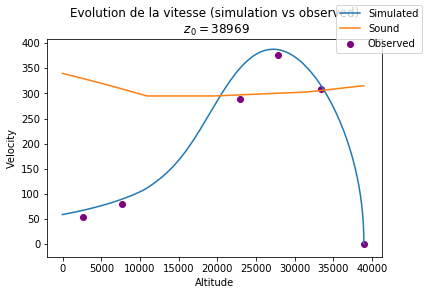

In [9]:
chute(260, 38969, 110, 1.3, .4, observed=True)

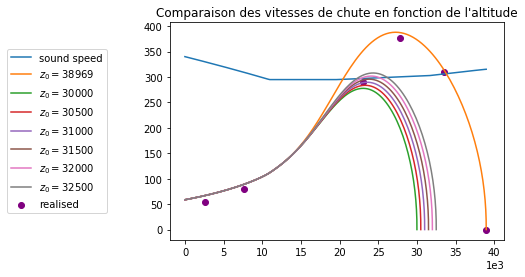

In [10]:
fig, ax = plt.subplots()
ax.set_title("Comparaison des vitesses de chute en fonction de l'altitude")
[z, u, vs] = chute(260, 38969, 110, 1.3, .4, plot=False)
ax.plot(z, vs, label="sound speed")
z_observed = np.array([38969, 33446, 27833, 22961, 7619, 2567])
v_observed = np.array([0, 1115, 1358, 1043, 285, 192])*1000/3600
ax.scatter(z_observed, v_observed, label='realised', c='purple')
ax.plot(z, -u, label="$z_0 = 38969$")

for i in range(30000, 33000, 500):
    [z, u, vs] = chute(260, i, 110, 1.3, .4, plot=False)
    ax.plot(z, -u, label=f"$z_0 = {i}$")
    ax.legend(loc='center left', bbox_to_anchor=[-.5, .5]);
    ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])